### Time Series Decomposition
##### Decomposition is basically applied in time series analysis, it can also be used as a tool to inform forecasting models on a problem

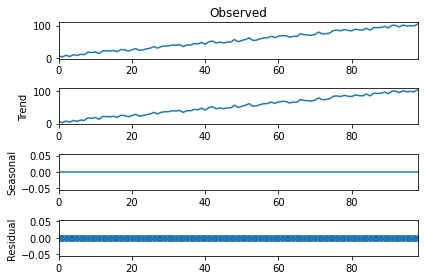

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
# series = pd.read_csv("waterTankNew.csv", header=0, index_col=0).values
# result = seasonal_decompose(series, model='multiplicative', period=1)
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
pyplot.show()

Differenced


<AxesSubplot:xlabel='time'>

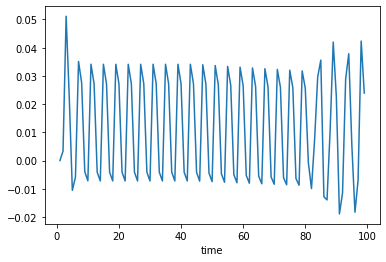

In [3]:
# Differencing
series = pd.read_csv("waterTankNew.csv", header=0, index_col=0)[0:100]
# series['Tank1WaterLevel'].dropna().plot()
series['Tank1WaterLevel_diff'] = series['Tank1WaterLevel'] - series['Tank1WaterLevel'].shift(1)
print("Differenced")
series['Tank1WaterLevel_diff'].dropna().plot()

### Test for Stationarity - constant mean and variance

In [4]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
# ADF Test - null hypothesis - non-stationary - if p-value < 5% reject null hypothesis
# adfuller_result = adfuller(series, autolag="AIC")
tankData = pd.read_csv("waterTankNew.csv", header=0, index_col=0)
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
# adfuller_result = adfuller(tankData["wt3_valve"].values, autolag="AIC")

for feature in attr:
    
    adfuller_result = adfuller(tankData[feature].values, autolag="AIC")
    print("Stationarity metrics for each series")
    print(f'ADF Statistic: {adfuller_result[0]}')
    print(f'p-value: {adfuller_result[1]}')

    for key, value in adfuller_result[4].items():
        print('Critical Values: ')
        print(f'    {key}, {value}')

    print("Conclusion")
    if adfuller_result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")
    print("\n\n")

Stationarity metrics for each series
ADF Statistic: -10.822054077857318
p-value: 1.7952203957037132e-19
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -8.445124611888938
p-value: 1.721056922432247e-13
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -12.552326253149165
p-value: 2.192107228681411e-23
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -10.547888979097348
p-value: 8.321350953780787e-19
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.8616

### How to make the time series stationary

### Forecasting fewer outputs with Enc-Dec LSTM

### visualise the data

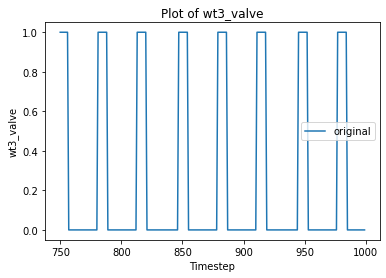

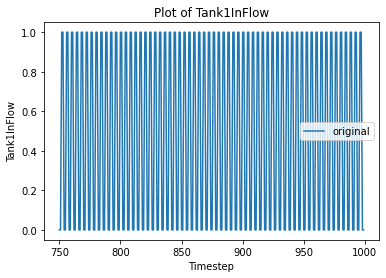

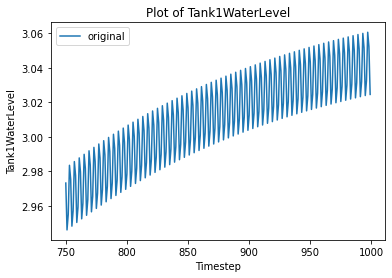

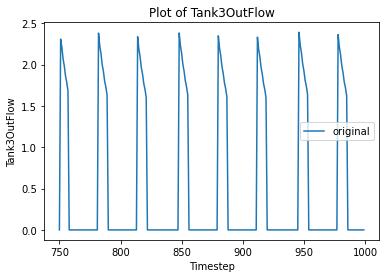

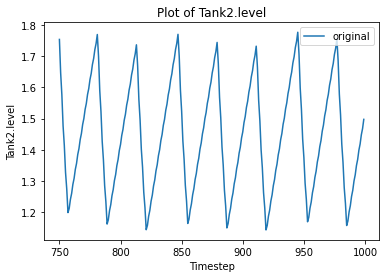

In [5]:
from pandas import read_csv
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)

attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Plot of "+str(attr[i])
#     actual = mydata.iloc[:2000,i]
    actual = mydata.iloc[750:1000,i]
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(actual, label="original")
    plt.legend()
    plt.show()

In [ ]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)
data = read_csv('waterTankNew.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 14000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
# n_steps_in, n_steps_out = 50, 100
n_steps_in, n_steps_out = 50, 100

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(10, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=70, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

#save the model to disk
model.save('Enc-Dec-lstm2.h5')
print("Model saved!")

The shape of the raw_data before scaling is (20001, 5)
Epoch 1/70
433/433 - 18s - loss: 0.1539 - 18s/epoch - 41ms/step
Epoch 2/70
433/433 - 16s - loss: 0.1157 - 16s/epoch - 36ms/step
Epoch 3/70
433/433 - 16s - loss: 0.1141 - 16s/epoch - 36ms/step
Epoch 4/70
433/433 - 16s - loss: 0.0867 - 16s/epoch - 36ms/step
Epoch 5/70
433/433 - 16s - loss: 0.0807 - 16s/epoch - 37ms/step
Epoch 6/70
433/433 - 16s - loss: 0.0763 - 16s/epoch - 37ms/step
Epoch 7/70
433/433 - 16s - loss: 0.0709 - 16s/epoch - 37ms/step
Epoch 8/70
433/433 - 16s - loss: 0.0675 - 16s/epoch - 37ms/step
Epoch 9/70
433/433 - 16s - loss: 0.0683 - 16s/epoch - 37ms/step
Epoch 10/70
433/433 - 16s - loss: 0.0661 - 16s/epoch - 37ms/step
Epoch 11/70
433/433 - 16s - loss: 0.0649 - 16s/epoch - 37ms/step
Epoch 12/70
433/433 - 16s - loss: 0.0659 - 16s/epoch - 37ms/step
Epoch 13/70
433/433 - 16s - loss: 0.0636 - 16s/epoch - 37ms/step
Epoch 14/70
433/433 - 17s - loss: 0.0648 - 17s/epoch - 40ms/step
Epoch 15/70
433/433 - 17s - loss: 0.0639 - 1

In [15]:
len(inv_yhat.T)

5

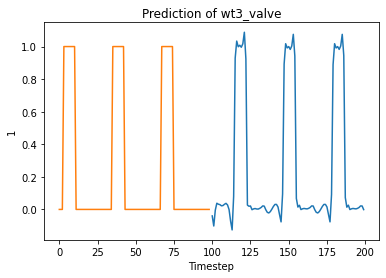

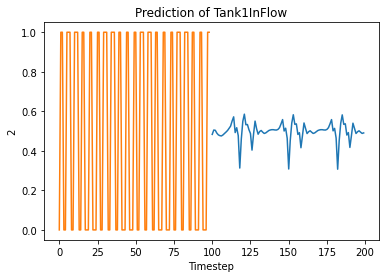

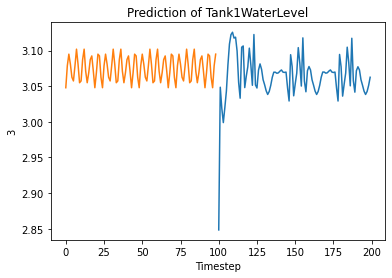

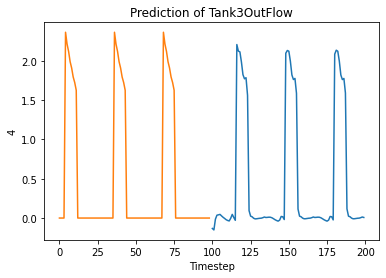

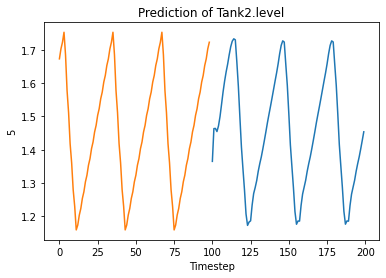

In [16]:
attr = len(inv_yhat.T)
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[9901:10000,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i+1)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

# Load the pre-trained surrogate model

In [17]:
from keras.models import load_model

s_model = load_model('Enc-Dec-lstm.h5')

new_data = scaled_data[10000:12000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
# test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))


print("Prediction is successful!")

loss:  5.07%
1
Prediction is successful!


### Fault Injection

In [18]:
## Fault Injection
from pandas import read_csv
from random import randint
# from random import random
import random
import math


def inject_Fault_Univariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for i in range(len(data)):
        p = random.random()
        if p > 0.5:
            data["column"].iloc[i] += random.choice(fault_units)
            
    return data

def randomised(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for col in data.columns:
        
        for i in range(len(data)):
            p = random.random()
            if p > 0.5:
                data[col].iloc[i] += random.choice(fault_units)

    return data


def value_flip(data, loc, col):
    for dp in data.index[loc]:
        if(data.loc[dp, col] == 1):
            data.loc[dp, col] = 0
        else:
            data.loc[dp, col] = 1            
    return data


def stuck_at(data, loc, col, val):
    # This is either stuck_at zero or at 1
    for dp in data.index[loc]:
        data.loc[dp, col] = val
    return data

def insert_outlier(data, loc, col):
#     // This inserts at the beginning of the data
    thresh = random.uniform(0.5, 1.5)
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    high_outlier = q3 + 1.5*iqr
    low_outlier = q1 - 1.5*iqr - thresh
    for dp in data.index[loc]:
        data.loc[dp, col] =high_outlier + random.uniform(0.5, 1.5)
#         data.loc[dp, col] =low_outlier - random.uniform(0.5, 1.5)
    return data


def stuck2_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data



my_data = read_csv("waterTank.csv", header=0)
my_data = my_data.iloc[1:50,:]

# myNewdata = inject_Fault_Univariate(my_data)
myNewdata = randomised(my_data)
myNewdata.to_csv("Randomised_data.csv")

flipped_data = value_flip(my_data, "Tank1InFlow")
flipped_data.to_csv("flipped_data.csv")

outliered = insert_outlier(my_data, "Tank2WaterLevel")
outliered.to_csv("outlier_data.csv")

stuck_data = stuck_at(my_data, 1, "Tank1InFlow", loc="beg")
stuck_data.to_csv("stuck_at_one.csv")

print("Files saved successfully")

C:\Users\user\AppData\Local\Temp\ipykernel_9928\2515031583.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].iloc[i] += random.choice(fault_units)


NameError: name 'bit_flip' is not defined

In [161]:
import pandas as pd
import random
from numpy import array
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


def insert_outlier(data, loc, col):
#     // This inserts at the beginning of the data
    thresh = random.uniform(0.5, 1.5)
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    high_outlier = q3 + 1.5*iqr
    low_outlier = q1 - 1.5*iqr - thresh
    for dp in data.index[loc]:
        data.loc[dp, col] =high_outlier + random.uniform(0.5, 1.5)
#         data.loc[dp, col] =low_outlier - random.uniform(0.5, 1.5)
    return data

def stuck_at(data, loc, col, val):
    # This is either stuck_at zero or at 1
    for dp in data.index[loc]:
        data.loc[dp, col] = val
    return data


# mydata = read_csv('simulated_waterTank.csv', header=0, index_col=0, skiprows=4)
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)
# faulty_data = value_flip(mydata, range(100), "Tank1InFlow")
# faulty_data = insert_outlier(mydata, range(100), "Tank1InFlow")
faulty_data = stuck_at(mydata, range(500,700), "Tank1InFlow", 1)
faulty_data.to_csv('outlier_faulty_data1.csv')
faulty_data.head()
# mydata

,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank3OutFlow,Tank2.level
time,,,,,
0,0,0,1.000000e-06,0.0,0.0
1,0,0,6.890000e-07,0.0,0.0
2,0,1,3.333928e-03,0.0,0.0
3,0,1,5.448433e-02,0.0,0.0
4,0,0,7.717051e-02,0.0,0.0


### Predict with faulty data (Outlier)

In [19]:
s_model = load_model('Enc-Dec-lstm.h5')

data = read_csv('outlier_faulty_data1.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

resh_test_yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {resh_test_yhat.shape}')
res_inv_yhat = scaler.inverse_transform(resh_test_yhat)
print(res_inv_yhat)


print(len(s_model.metrics_names))
print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  7.28%
The new shape of yhat  is (100, 5)
[[-3.9899632e-02  4.8330095e-01  2.8482502e+00 -1.3245513e-01
   1.3648663e+00]
 [-1.0184598e-01  5.0528020e-01  3.0486398e+00 -1.5090469e-01
   1.4634753e+00]
 [-4.5325160e-03  5.0395262e-01  3.0190313e+00 -1.4080478e-02
   1.4639256e+00]
 [ 3.7993133e-02  4.8975918e-01  2.9989471e+00  3.6502309e-02
   1.4545372e+00]
 [ 3.2068521e-02  4.8079219e-01  3.0202715e+00  4.0714141e-02
   1.4714936e+00]
 [ 2.9519767e-02  4.7688884e-01  3.0430987e+00  4.6385009e-02
   1.4994849e+00]
 [ 2.2146523e-02  4.7543550e-01  3.0797658e+00  2.7190682e-02
   1.5361904e+00]
 [ 2.3714215e-02  4.8043078e-01  3.1091144e+00  9.8052258e-03
   1.5737745e+00]
 [ 3.1580269e-02  4.8780683e-01  3.1224389e+00 -5.0488277e-03
   1.6060897e+00]
 [ 3.7306070e-02  4.9502009e-01  3.1258278e+00 -2.0734612e-02
   1.6339221e+00]
 [ 2.7473330e-02  5.0290710e-01  3.1176205e+00 -3.0817598e-02
   1.6576260e+00]
 [-1.0906160e-03 

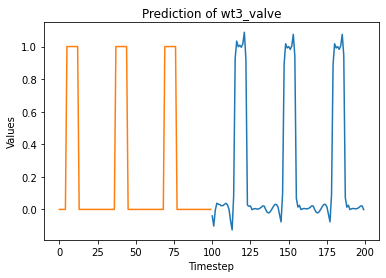

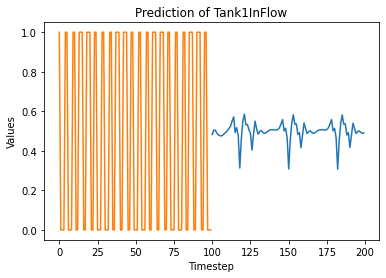

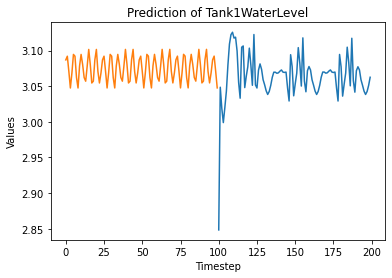

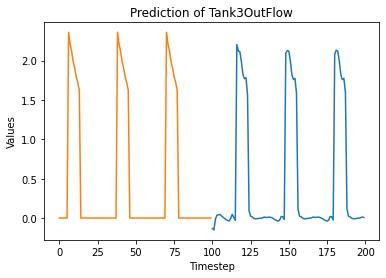

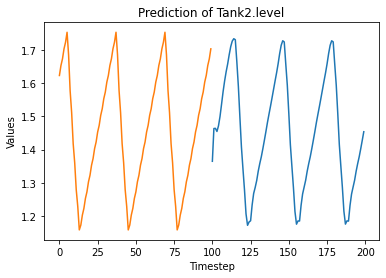

In [20]:
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[1900:2000,i]
    pred = res_inv_yhat.T
    pred_df = pd.DataFrame(res_inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

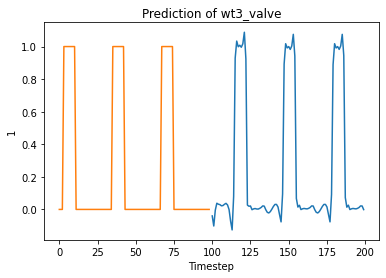

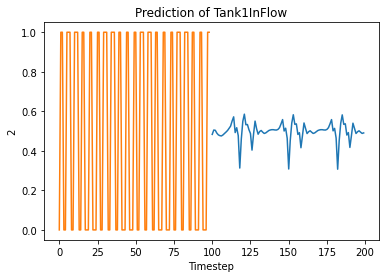

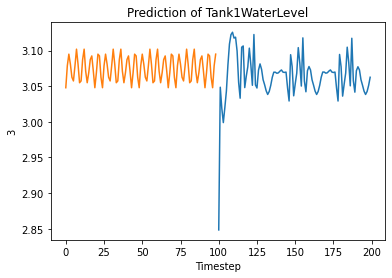

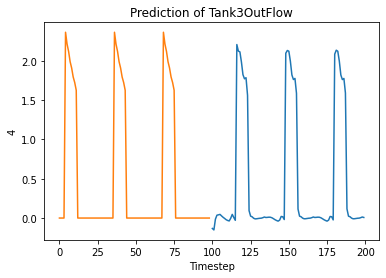

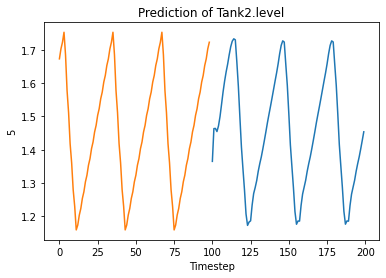

In [21]:
attr = len(inv_yhat.T)
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[9901:10000,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i+1)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

### Forecasting fewer outputs with Enc-Dec GRU

In [112]:
import random
random.uniform(0.5, 1.5)

0.5333138794331193

In [65]:
# newList = [x for x in mydata.iloc[range(5),0]]
result = [x for x in mydata.iloc[range(5),0]]
print(result)

[4, 0, 0, 0, 0]


In [66]:
df = pd.DataFrame({'A': [1,2,3,4], 'B': [5,6,7,8], 'C': [9,10,11,12]})
print("Original dataframe")
print(df)
col = 'A'
df.loc[1:2, col] = 20
df.loc[3, 'C'] = 30

print("\nModified dataframe")
print(df)

Original dataframe
   A  B   C
0  1  5   9
1  2  6  10
2  3  7  11
3  4  8  12

Modified dataframe
    A  B   C
0   1  5   9
1  20  6  10
2  20  7  11
3   4  8  30


In [122]:
time_series = np.array([1,2,3,4,5,6,7,8,9,10])
mean = 0
std_dev = 1
noise = np.random.normal(mean, std_dev, len(time_series))
noisy_time_series = time_series[4:8] + noise[4:8]
print("Original time series:", time_series)
print("Noisy time series:", noisy_time_series)

Original time series: [ 1  2  3  4  5  6  7  8  9 10]
Noisy time series: [5.23544862 5.03933424 6.28966049 7.3269596 ]
